In [17]:
import os
import sys
import numpy as np
import pandas as pd
import math
import sys
import pickle

import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule
from pyro.infer import Predictive

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '/home/djl34/lab_pd/kl/git/KL/scripts')
import raklette

from run_raklette import run_raklette
from run_raklette import TSVDataset
import post_analysis
from others import round_sig

import seaborn as sns
import matplotlib.pyplot as plt

##############################################################################################################

KL_data_dir = "/home/djl34/lab_pd/kl/data"
scratch_dir = "/n/scratch3/users/d/djl34"

base_set = ["A", "C", "T", "G"]
chrom_set = [str(x) for x in range(1, 23)]

file_directory = "single_feature/nonsense/"


In [2]:
client = Client()

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36417 instead
  warnings.warn(


## get beta

In [3]:
chrom_set = ["22"]
chrom_set = [str(x) for x in range(1, 23)]


header_name_list = ["nonsense_below_5_pivot_", "nonsense_above_5_pivot_"]

# header = "footprints_gene_"

covprior_list = [0.1]
learning_rate_list = [0.01]
interval_list = [""]

# sample_size = 100000000
sample_size = -1

chunksize = 1000000
epoch = 800

header_list = []

def get_file_header(header, chrom, sample_size, lr, gamma, chunksize, epoch, cov_prior):
    
    if sample_size == -1:
        return os.path.join(KL_data_dir, "raklette_output/" + file_directory + header + "chr_" + chrom + "_chunksize_" 
                            + str(chunksize) + "_covonly_lr_" + str(lr) + "_gamma_" + str(gamma) +"_epoch_" + 
                            str(epoch)+ "_covprior_" + str(cov_prior))
    else:
        return os.path.join(KL_data_dir, "raklette_output/" + file_directory + header  + "sample_"+ str(sample_size) 
                            + "_chr_" + chrom +"_chunksize_"+ 
                            str(chunksize) + "_covonly_lr_" + str(lr) + "_gamma_" + str(gamma) +"_epoch_" + 
                            str(epoch)+ "_covprior_" + str(cov_prior))
    

for header in header_name_list:
    for interval in interval_list:
        for prior in covprior_list:
    #         print(prior)
            for lrate in learning_rate_list:
    #             print(lrate)
                for chrom in chrom_set:
                    lr, gamma, cov_prior, chrom = (lrate, 0.5, prior, chrom)

                    file_header = get_file_header(header + interval , chrom, sample_size, lr, gamma, chunksize, epoch, cov_prior)

                    header_list.append(file_header)

## check for fit

In [10]:
file_header = header_list[-1]

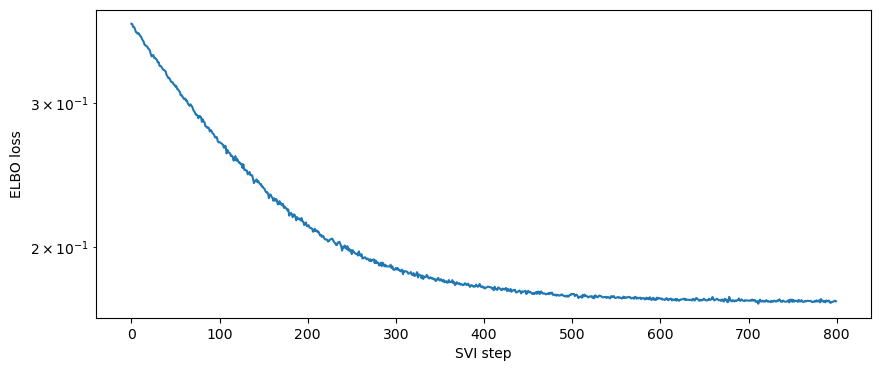

In [4]:
with open(header_list[-1] + ".pkl", 'rb') as handle:
    dictionary = pickle.load(handle)

In [7]:
dictionary.keys()

dict_keys(['neut_sfs_full', 'beta_neut_full', 'ref_mu_ii', 'cov_sigma_prior', 'losses', 'fig'])

## get_fit_values

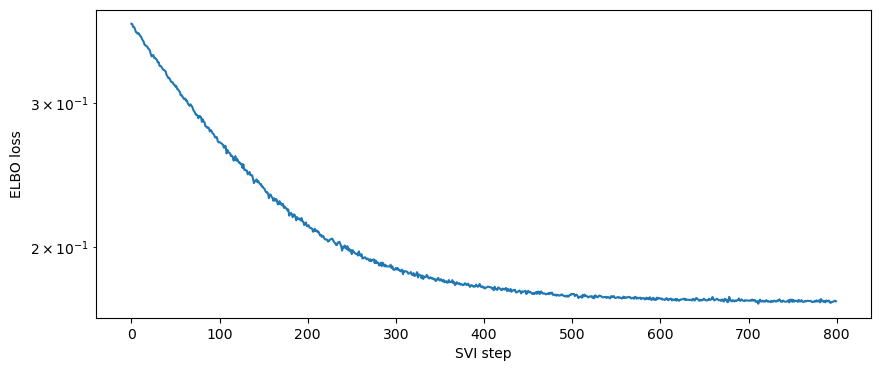

In [41]:
with open(file_header + ".pkl", 'rb') as handle:
    result = pickle.load(handle)

dictionary = post_analysis.read_model(file_header)

In [44]:
ref_mu_ii = result["ref_mu_ii"]
neut_sfs_full = result["neut_sfs_full"]

In [19]:
dictionary

{'KL': <raklette.raklette_cov at 0x7ffaa8199a60>,
 'model': <bound method raklette_cov.model of <raklette.raklette_cov object at 0x7ffaa8199a60>>,
 'guide': AutoNormal(
   (locs): PyroModule()
   (scales): PyroModule()
 )}

In [38]:
KL = dictionary["KL"]
guide = dictionary["guide"]

beta_neut = KL.beta_neut
beta_neut_full = KL.beta_neut_full
beta_cov = guide.median()['beta_cov']
beta_cov_trans = torch.cumsum(beta_cov, dim=-1)


post_probs = raklette.softmax(raklette.pad(beta_neut - beta_cov_trans)).detach().numpy()

In [46]:
KL_fw_post = raklette.KL_fw(neut_sfs_full[ref_mu_ii,:].detach().numpy(), post_probs)
KL_rv_post = raklette.KL_rv(neut_sfs_full[ref_mu_ii,:].detach().numpy(), post_probs)

In [48]:
KL_fw_post

array([0.01987982, 0.02021673, 0.10800179, 0.02740867, 0.05654879,
       0.016029  , 0.0291259 , 0.06585588, 0.02670892, 0.04071067,
       1.53351307, 0.01862996, 0.01680207, 0.32143578, 0.01508926,
       0.01895785, 0.02700751, 0.01964703, 0.02526479, 0.023092  ,
       0.02269134, 0.02880447, 1.71663053, 0.02222779, 0.04437924,
       0.12077905, 0.06871852, 0.01695334, 0.02069917, 0.02398255,
       0.02439254, 0.04946627, 0.04290475, 0.01213723, 0.05363019,
       0.02129704, 0.17640795, 0.32792892, 0.02422573, 0.01335148,
       0.02798665, 0.01376072, 0.02378938, 0.04618496, 0.58995172,
       0.02196112, 0.02562051, 0.8580526 , 0.02336921, 2.96547367,
       3.88036033, 0.01935492, 0.10874391, 0.0212574 , 0.01982872,
       0.01707443, 1.6029192 , 0.0218121 , 0.02482533, 0.17891622,
       0.30034878, 0.02215191, 0.02068392, 0.92578028, 1.9380707 ,
       0.02758083, 0.02099223, 0.27517687, 0.03145825, 0.02492503,
       0.0390739 , 0.08700557, 0.03050345, 0.02681051, 0.04828

In [60]:
KL_rv_post.shape

(157,)

## put it together into a pandas dataframe

In [49]:
filename = os.path.join(scratch_dir, "kl_input/" + file_directory + "nonsense_above_5_pivot_chr_22.tsv")
df = pd.read_csv(filename, sep = "\t")

In [59]:
df = pd.DataFrame(zip(list(df.columns[2:]), list(KL_fw_post), list(KL_rv_post)), columns = ["Gene", "KL_fw", "KL_rv"])

,Gene,KL_fw,KL_rv
0,ENSG00000025708,0.019880,0.020466
1,ENSG00000040608,0.020217,0.021231
2,ENSG00000056487,0.108002,0.165152
3,ENSG00000069998,0.027409,0.029593
4,ENSG00000073146,0.056549,0.071472
...,...,...,...
152,ENSG00000244509,0.032707,0.034824
153,ENSG00000250479,0.014482,0.014762
154,ENSG00000251357,0.013897,0.014093
155,ENSG00000254709,0.019491,0.019728


In [61]:
df = pd.read_csv("/home/djl34/lab_pd/kl/data/raklette_output/single_feature/nonsense/nonsense_above_5_pivot_chr_22_chunksize_1000000_covonly_lr_0.01_gamma_0.5_epoch_800_covprior_0.1_KL.tsv", sep = "\t")

In [62]:
df

,Gene,KL_fw,KL_rv
0,ENSG00000025708,0.019880,0.020466
1,ENSG00000040608,0.020217,0.021231
2,ENSG00000056487,0.108002,0.165152
3,ENSG00000069998,0.027409,0.029593
4,ENSG00000073146,0.056549,0.071472
...,...,...,...
152,ENSG00000244509,0.032707,0.034824
153,ENSG00000250479,0.014482,0.014762
154,ENSG00000251357,0.013897,0.014093
155,ENSG00000254709,0.019491,0.019728
